# Laplace Transform — Three Views (v2.2 · Basenji Theme)

This version keeps all animations but updates the **visual style** to match the attached reference:
- Deep blue background
- Cyan grid accents
- Soft highlights
- **Font:** *Basenji Variable* (if available), otherwise fallback to a safe sans-serif.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, font_manager
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
from IPython.display import HTML, display
from scipy import integrate
import os

# ----- Typography: Prefer 'Basenji Variable' if present -----
font_manager.fontManager.addfont("BasenjiVariable.otf")
plt.rcParams["font.family"] = "Basenji Variable"
preferred_font = 'Basenji Variable'

# Try to locate the font if user has it installed or placed next to the notebook
# You can drop a file like 'BasenjiVariable.ttf' in the working directory to load it automatically.
possible_files = [
    'BasenjiVariable.ttf', 'BasenjiVariable.otf', 'Basenji Variable.ttf', 'Basenji Variable.otf'
]
for f in possible_files:
    if os.path.exists(f):
        try:
            font_manager.fontManager.addfont(f)
        except Exception as e:
            print('Font add failed:', e)

# Check if Matplotlib recognizes the family name
available = [f.name for f in font_manager.fontManager.ttflist]
if preferred_font in available:
    base_font = preferred_font
else:
    base_font = 'DejaVu Sans'

# ----- Theme (Basenji-inspired blue) -----
BG = '#0e3a8a'            # deep blue background
PANEL = '#0f47b6'         # slightly lighter for panels (if needed)
GRID = '#5ad4ff'          # cyan grid
TEXT = '#e6f0ff'          # very light text
ACCENT_PINK = '#ff79c6'   # magenta-pink
ACCENT_YELLOW = '#ffd166' # warm yellow
ACCENT_CYAN = '#5df2d6'   # teal-cyan
ACCENT_WHITE = '#ffffff'  # white for cursors/lines

plt.rcParams.update({
    'figure.facecolor': BG,
    'axes.facecolor': BG,
    'savefig.facecolor': BG,
    'axes.edgecolor': GRID,
    'axes.labelcolor': TEXT,
    'text.color': TEXT,
    'xtick.color': GRID,
    'ytick.color': GRID,
    'grid.color': GRID,
    'grid.alpha': 0.35,
    'grid.linestyle': '--',
    'axes.grid': True,
    'figure.dpi': 120,
    'font.size': 12,
    'axes.titleweight': 'bold',
    'font.family': base_font
})

def show_anim(anim, fps=15, save_mp4_path=None):
    """Render as HTML5 video when possible, fallback to JSHTML otherwise."""
    try:
        html5 = anim.to_html5_video()
        if save_mp4_path:
            try:
                writer = animation.FFMpegWriter(fps=fps)
                anim.save(save_mp4_path, writer=writer)
                print(f"Saved MP4 to: {save_mp4_path}")
            except Exception as e:
                print("MP4 save skipped:", e)
        return HTML(html5)
    except Exception as e:
        print("HTML5 video fallback (no ffmpeg):", e)
        return HTML(anim.to_jshtml())


## View 1 — Decay of $e^{-\sigma t}$


In [2]:
fs = 200
Tmax = 5.0
t = np.linspace(0, Tmax, int(fs*Tmax), endpoint=False)
sigmas = np.linspace(0.0, 2.0, 40)

fig, ax = plt.subplots(figsize=(7.2, 3.6))
(line,) = ax.plot([], [], lw=2.6, color=ACCENT_PINK)
ax.set_xlim(0, Tmax); ax.set_ylim(0, 1.05)
ax.set_xlabel('t'); ax.set_ylabel('e^{-σ t}')
ax.set_title('Kernel decay as σ increases')
legend_txt = ax.text(0.98, 0.92, '', ha='right', va='center', transform=ax.transAxes, color=ACCENT_YELLOW)

def init():
    line.set_data([], []); legend_txt.set_text('')
    return (line, legend_txt)

def animate(i):
    sigma = sigmas[i]
    y = np.exp(-sigma * t)
    line.set_data(t, y)
    legend_txt.set_text(f'σ = {sigma:.2f}')
    return (line, legend_txt)

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=len(sigmas), interval=80, blit=True)
display(show_anim(anim, fps=12, save_mp4_path='v22_view1_decay.mp4')); plt.close(fig)


Saved MP4 to: v22_view1_decay.mp4


## View 2 — Weighting & Accumulation


In [3]:
fs = 200
Tmax = 6.0
t = np.linspace(0, Tmax, int(fs*Tmax), endpoint=False)
sigma = 0.6
f = np.sin(2*np.pi*1.0*t)
kernel = np.exp(-sigma * t)
integrand = f * kernel
cum_int = integrate.cumulative_trapezoid(integrand, t, initial=0.0)

fig, ax = plt.subplots(figsize=(8.0, 4.4))
ax.set_xlim(0, Tmax)
ax.set_ylim(min(integrand.min()-0.2, -1.2), max(integrand.max()+0.2, 1.2))
ax.set_xlabel('t'); ax.set_ylabel('amplitude')
ax.set_title('f(t) weighted by e^{-σ t} and running integral')

ax.plot(t, f, lw=1.2, color=ACCENT_YELLOW, label='f(t)')
ax.plot(t, kernel, lw=1.2, color=ACCENT_CYAN, label='e^{-σ t}')
(line_fk,) = ax.plot(t, integrand, lw=1.8, color=ACCENT_PINK, label='f(t)e^{-σ t}')
cursor = ax.axvline(0, color=ACCENT_WHITE, lw=1.6, linestyle=':')
ax.legend(loc='upper right')

ax2 = ax.twinx()
(line_cum,) = ax2.plot([], [], lw=2.0, color=ACCENT_WHITE)
ax2.set_ylabel('I(T) = ∫_0^T f(τ)e^{-σ τ} dτ')

txt_T = ax.text(0.02, 0.92, '', transform=ax.transAxes, color=ACCENT_WHITE, fontsize=12)
txt_I = ax2.text(0.98, 0.08, '', transform=ax2.transAxes, ha='right', color=ACCENT_WHITE, fontsize=12)

frames = 180
indices = np.linspace(2, len(t), frames, dtype=int)
fill_coll = [None]

def init():
    line_cum.set_data([], [])
    return (line_fk, line_cum, cursor)

def animate(i):
    idx = indices[i]
    ti = t[:idx]; yi = integrand[:idx]; Ii = cum_int[:idx]

    if fill_coll[0] is not None:
        try: fill_coll[0].remove()
        except Exception: pass
    fill_coll[0] = ax.fill_between(ti, yi, 0, color=ACCENT_PINK, alpha=0.18)

    cursor.set_xdata(t[idx-1])
    line_cum.set_data(ti, Ii)

    txt_T.set_text(f'T = {t[idx-1]:.2f} s,  σ = {sigma:.2f}')
    txt_I.set_text(f'I(T) = {Ii[-1]:.4f}')
    return (line_fk, line_cum, cursor)

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=len(indices), interval=60, blit=False)
display(show_anim(anim, fps=15, save_mp4_path='v22_view2_weighting.mp4')); plt.close(fig)


C:\Users\felip\AppData\Local\Temp\ipykernel_31644\2081663625.py:46: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  cursor.set_xdata(t[idx-1])
C:\Users\felip\AppData\Local\Temp\ipykernel_31644\2081663625.py:46: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  cursor.set_xdata(t[idx-1])


Saved MP4 to: v22_view2_weighting.mp4


## View 3 — s-plane Sweep for $F(s)=\frac{1}{s+1}$


In [4]:
omegas = np.linspace(0, 12*np.pi, 600)
sigmas = np.linspace(-0.5, 2.0, 45)

fig, ax = plt.subplots(figsize=(7.6, 4.2))
ax.set_xlim(0, np.max(omegas)); ax.set_ylim(0, 1.2)
ax.set_xlabel('ω'); ax.set_ylabel('|F(σ + jω)|')
ax.set_title('Magnitude along σ + jω for F(s)=1/(s+1)')
(line,) = ax.plot([], [], lw=2.2, color=ACCENT_CYAN)
txt = ax.text(0.02, 0.90, '', transform=ax.transAxes, color=ACCENT_YELLOW, fontsize=12)

def init():
    line.set_data([], []); txt.set_text('')
    return (line, txt)

def animate(i):
    sigma = sigmas[i]
    Fmag = 1.0/np.sqrt((sigma+1.0)**2 + omegas**2)
    line.set_data(omegas, Fmag); txt.set_text(f'σ = {sigma:.2f}  (ROC: Re(s) > -1)')
    return (line, txt)

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=len(sigmas), interval=80, blit=True)
display(show_anim(anim, fps=12, save_mp4_path='v22_view3_splane.mp4')); plt.close(fig)


Saved MP4 to: v22_view3_splane.mp4


## View 4 — 3D Surface of $|1/s|$ (Basenji Theme)


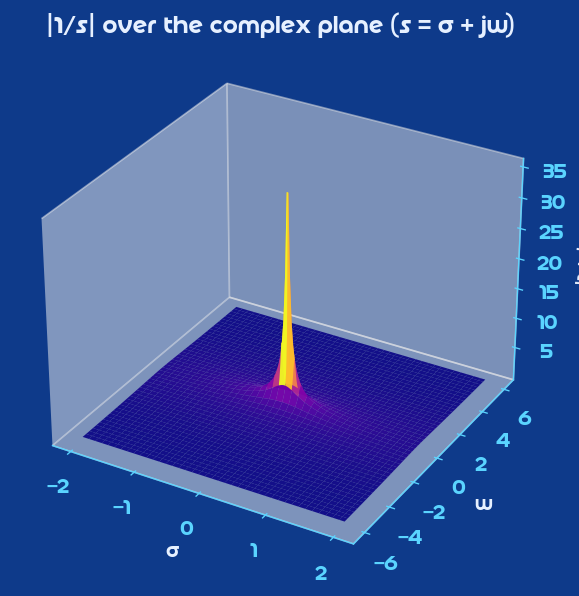

Saved MP4 to: v22_view4_surface3d.mp4


In [5]:
sigma_min, sigma_max = -2.0, 2.0
omega_min, omega_max = -6.0, 6.0
n_sigma, n_omega = 160, 240

sigma = np.linspace(sigma_min, sigma_max, n_sigma)
omega = np.linspace(omega_min, omega_max, n_omega)
S, W = np.meshgrid(sigma, omega, indexing='xy')

R = np.sqrt(S**2 + W**2)
Z = 1.0 / np.maximum(R, 1e-6)

fig = plt.figure(figsize=(8.0, 5.8))
ax = fig.add_subplot(111, projection='3d')
ax.set_facecolor(BG)
surf = ax.plot_surface(S, W, Z, cmap='plasma', linewidth=0, antialiased=True, alpha=0.95)
ax.set_xlabel('σ'); ax.set_ylabel('ω'); ax.set_zlabel('|1/s|')
ax.set_title('|1/s| over the complex plane (s = σ + jω)')
ax.grid(False)
plt.show()

fig2 = plt.figure(figsize=(8.0, 5.8))
ax2 = fig2.add_subplot(111, projection='3d')
ax2.set_facecolor(BG)
surf2 = ax2.plot_surface(S, W, Z, cmap='plasma', linewidth=0, antialiased=True, alpha=0.95)
ax2.set_xlabel('σ'); ax2.set_ylabel('ω'); ax2.set_zlabel('|1/s|')
ax2.set_title('Rotating view: |1/s| surface')
ax2.grid(False)

def init():
    ax2.view_init(elev=24, azim=30)
    return (surf2,)

def animate(frame):
    ax2.view_init(elev=24, azim=30 + frame)
    return (surf2,)

anim3d = animation.FuncAnimation(fig2, animate, init_func=init, frames=180, interval=40, blit=False)
display(show_anim(anim3d, fps=24, save_mp4_path='v22_view4_surface3d.mp4')); plt.close(fig2)
